# BioSound Tutorial 5.  Using the Spectrogram as features for classifiers.
### In tutorial 4, you learned how to use predefined acoustical features such as pitch saliency to classify sounds.  Here you will use a spectrogram.  The plotDiscriminate routine performs a PCA on these large feature spaces to prevent over-fitting 

Some things to note:  The spectrogram approach will only work if all BioSound files have the same size spectrogam.  This usually means the same sound length and the same time-frequency scale. Here spectrograms are cut to the smallest soud. It also makes sense to have a logical alignment since the approach will be sensitive to shifts. This code can easily be modified to also use the modulation power spectrum. 
The modulation spectrum allows for variable size sounds and is insensitive to shifts but the analysis window for the MPS must be identical and it must be based on spectrograms that were obtained with the same time-frequency scale.

## Step 1. Loading all the dependencies.  
### numpy, matplotlib and soundsig should have been installed when you installed soundsig.  You might have to also install pandas, pickle and sklearn.

In [1]:
# Import math, pandas and soundsig libraries
import numpy as np
import pandas as pd
from soundsig.sound import BioSound 
#from soundsig.discriminate import discriminatePlot
import sys
sys.path.append('./soundsig/soundsig')
from discriminate import discriminatePlot

import pickle
from sklearn.decomposition import PCA
from scipy.stats.mstats import zscore

import os


## Step 2. Specifying the location of the sound files in BioSound format (h5 files).

YOU WILL WANT TO CHANGE TO FOLLOWING CODE TO POINT TO THE RIGHT PLACE  
You will also want to change the location for storing the pandas table.  
Note that you might want to also change the name of the h5 file that stores all of the spectrograms.

In [2]:
## Go to the folder that has the h5 files corresponding to the BioSound objects.
os.chdir('/Users/tobias/Documents/BioSoundTutorial-master/BatCalls/h5files')

# Some output files
tableStore = "Z:\\users\\JulieE\\DeafSalineGroup151\\DeafBats_BioSoundTutorialNotebooksData\\vocSelTableSpectro.h5"
pcInfo = "Z:\\users\\JulieE\\DeafSalineGroup151\\DeafBats_BioSoundTutorialNotebooksData\\vocSpectroPC.pkl"

# This is where you want to store eps of figures that will be generated.
figdir = './'

## Step 3. Looping through a set of bioSoundObjects to extract the spectrogram and storing them into a Pandas Data Frame.

#### Part 1. Extract Spectrograms; normalize if desired; and compress by PCA

Here we are doing the PC to store the data efficiently.  Unless you have a ton of data the classifier will only use a small number of these anyway.  The first PCA is to reduce from the ~25000 (for these data) space of spectrogram to a space of 50.  As you will see this is able to capture almost 90% of the variance.

In [8]:
# Set true if you want to normalize all spectrograms.
normFlg = True

#nPCs is the number of PCs that will be used in the first dimensionality reduction
nPCs = 50

# Read first one to allocate space for np array
count = 0
shapeSpectro = []
birdName = []
callType = []
for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        myBioSound = BioSound()
        myBioSound.readh5(fname)
        
        shapeSpectro.append(myBioSound.spectro.shape)
        birdName.append(np.array2string(myBioSound.emitter)[2:-1])
        callType.append(np.array2string(myBioSound.type)[2:-1])
        
        count += 1
   
shapeSpectro.sort()
shapeDesired = (93, 200)

X = np.zeros((count, shapeDesired[0]*shapeDesired[1]))
print('Allocated space for all spectrograms')
print(shapeDesired)


Allocated space for all spectrograms
(93, 200)


In [9]:
myBioSound.fo[45]

5031.446540880503

In [10]:
import pdb
def pad_vector(vector, depth, constant_value=0):
    vect_shape = vector.shape[:2]
    pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
    #pdb.set_trace()
    vector = np.hstack(tup=(pp, vector))
    #pdb.set_trace()
    pv = np.hstack(tup=(vector, pp))
    return pv

def symmetric_padding(vector, shapedDesired):
    # This function padds zeros to the left and right of the spectogram
    difference = shapeDesired[1] - vector.shape[1]
    number_of_zeros = 0
    
    if difference % 2 == 0: # If even, divide by 2
        number_of_zeros = int(difference / 2)
    else:
        vector = vector[:,0:-1]
        number_of_zeros = int( (difference+1) / 2 )
    output_vector = pad_vector(vector, number_of_zeros,0)
    return output_vector

In [11]:
# Loop again to extract spectrogram, store the in X and calculate PC 

# Looping through all the files
count = 0
list_of_spectros_lengths=[]
do_symmetric_padding = False

for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        
        # Allocate object and read data
        myBioSound.readh5(fname)
        
        # Massage spectrogram as in matlab code (DFA_Calls_Julie)
        if normFlg:  # Normalize by peak
            myBioSound.spectro -= myBioSound.spectro.max()

        # Set a 100 dB range threshold
        maxAmp = myBioSound.spectro.max();
        minAmp = maxAmp - 100;
        myBioSound.spectro[myBioSound.spectro < minAmp] = minAmp;
        shapeSpectro.append(myBioSound.spectro.shape)
        list_of_spectros_lengths.append(myBioSound.spectro.shape[1])
        if myBioSound.spectro.shape[1]<shapeDesired[1]:
            if do_symmetric_padding == True:
                #pdb.set_trace()
                #print(fname)
                try:
                    X[count, :] = np.ravel(symmetric_padding(myBioSound.spectro, shapeDesired))
                except:
                    pdb.set_trace()
            else: # Just padd at end
                X[count, 0:myBioSound.spectro.size] = np.ravel(myBioSound.spectro[0:shapeDesired[0], :])
        else:
            X[count, :] = np.ravel(myBioSound.spectro[0:shapeDesired[0], 0:shapeDesired[1]])
      
        count +=1
            
print('Read %d files and spectrograms' % count)
print('Performing PCA')

pca = PCA(n_components=nPCs)
Xr = pca.fit_transform(X)  
 
# Write PCA information in pkl                         
pcInfoFile = open(pcInfo, 'wb')

pickle.dump(pca.components_, pcInfoFile)

print('PCA Done: Wrote PC\'s to pickle file %s' % pcInfoFile)
print ('Variance explained is %.2f%%' % (sum(pca.explained_variance_ratio_)*100.0))

# Add pd spectrograms to dataframe



Read 5164 files and spectrograms
Performing PCA
PCA Done: Wrote PC's to pickle file <_io.BufferedWriter name='Z:\\users\\JulieE\\DeafSalineGroup151\\DeafBats_BioSoundTutorialNotebooksData\\vocSpectroPC.pkl'>
Variance explained is 90.96%


In [12]:
# Visualize the PCs
pca.fit(X)
print(pca.components_.shape)
print(pca.singular_values_)

(50, 18600)
[165379.81962934  56033.23100704  40625.75593547  29819.01803796
  23569.40408517  20949.19179634  18243.44723887  17318.34317973
  15504.08230415  14119.90840921  13109.01812515  12078.39742103
  11713.74620944  10956.19454448  10177.44205988   9786.34663762
   9229.59499189   8796.67085402   8580.74774921   8324.13923505
   7984.75948972   7538.31670207   7374.08036078   7212.37118916
   7184.56902162   7073.53676187   7010.37315564   6900.81850552
   6705.12086787   6454.57527522   6369.76854758   6245.54434273
   6102.21480828   5949.04133461   5850.78360841   5788.48671401
   5716.36904484   5464.2456401    5410.7289336    5341.59826874
   5247.47119161   5185.11146862   5020.43035869   4959.18640792
   4811.15600691   4634.66058489   4551.3431712    4427.53795622
   4398.54724535   4204.05507486]


min spectrogram length: 40
max spectrogram length: 7872
avg spectrogram length: 346.8801316808675
mode of spectrogram length: 56
95th%-ile point: 1389
median point: 136
.000001 point: 40


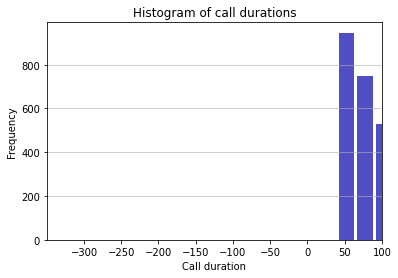

In [13]:
import matplotlib.pyplot as plt

print(f"min spectrogram length: {min(list_of_spectros_lengths)}")
print(f"max spectrogram length: {max(list_of_spectros_lengths)}")
avg_spectrogram_length = (np.mean(np.array(list_of_spectros_lengths)))
print(f"avg spectrogram length: {avg_spectrogram_length}")
from statistics import mode
mode2 = mode(list_of_spectros_lengths)
print(f"mode of spectrogram length: {mode2}")

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=list_of_spectros_lengths, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Call duration')
plt.ylabel('Frequency')
plt.title('Histogram of call durations')
plt.xlim(xmax=100)


list_of_spectros_lengths.sort()
ninety_fifth_point = list_of_spectros_lengths[int(len(list_of_spectros_lengths)*0.95)]
print(f"95th%-ile point: {ninety_fifth_point}")

median_point = list_of_spectros_lengths[int(len(list_of_spectros_lengths)*0.5)]
print(f"median point: {median_point}")

median_point = list_of_spectros_lengths[int(len(list_of_spectros_lengths)*0.000001)]
print(f".000001 point: {median_point}")


In [14]:
# Make the pandas data frame with all the spectrograms
vocSelData = []
for ic in range(count):         
    vocSelData.append({"Bird": birdName[ic], 
                       "Calltype": callType[ic], 
                       "Spectro": X[ic]}) 
     

# Make a panda data frame with all the data  
print('Reprocessed %d files to make Panda Data Frame'%count)                    
vocSelTable = pd.DataFrame(vocSelData)
vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')
print('Done: Wrote pandas data frame to h5 file %s' % tableStore)

Reprocessed 5164 files to make Panda Data Frame


c:\users\tobias\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Bird', 'Calltype', 'Spectro'], dtype='object')]

  encoding=encoding,


Done: Wrote pandas data frame to h5 file Z:\users\JulieE\DeafSalineGroup151\DeafBats_BioSoundTutorialNotebooksData\vocSelTableSpectro.h5


In [15]:
# Add deafness to the pandas table
BatStatus_name = ['F11648', 'M14461', 'F14463', 'M14464', 'F65696', 'M71043', 'F71047', 'M71351', 'F71353', 'F71354'];
BatStatus_sex = ['F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'F'];
BatStatus_deaf = [0, 0, 1, 0, 0, 1, 1, 1, 0, 1];

# Initialize name-deaf_status dict
bat_name_to_deaf_dict = dict(zip(BatStatus_name,BatStatus_deaf))
bat_name_to_sex_dict = dict(zip(BatStatus_name, BatStatus_sex))

# Add deaf status to dictionary
vocSelTable['isDeaf'] =  vocSelTable['Bird'].map(bat_name_to_deaf_dict) # Bird is actually Bat ID. 
isDeaf_array = np.array(vocSelTable['isDeaf'])
print(isDeaf_array)


vocSelTable['sex'] =  vocSelTable['Bird'].map(bat_name_to_sex_dict) # Bird is actually Bat ID. 
sex_array = np.array(vocSelTable['sex'])

[0 0 0 ... 1 1 1]


In [16]:
vocSelData = []
for ic in range(count):         
    vocSelData.append({ "isDeaf": isDeaf_array[ic],
                       "sex": sex_array[ic],
                       "Bird": birdName[ic], 
                       "Calltype": callType[ic], 
                       "Spectro": X[ic]}
                       ) 
    
# Make a panda data frame with all the data  
print('Reprocessed %d files to make Panda Data Frame'%count)                    
vocSelTable = pd.DataFrame(vocSelData)
vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')
print('Done: Wrote pandas data frame to h5 file %s' % tableStore)

Reprocessed 5164 files to make Panda Data Frame


c:\users\tobias\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['sex', 'Bird', 'Calltype', 'Spectro'], dtype='object')]

  encoding=encoding,


Done: Wrote pandas data frame to h5 file Z:\users\JulieE\DeafSalineGroup151\DeafBats_BioSoundTutorialNotebooksData\vocSelTableSpectro.h5


## Step 5.  Run the Classifiers.  
### You can also run only this code after reading vocSelTable

In [17]:
# You can start here (after loading dependencies) or skip if you already have vocSelTable

#Read the pandas table
vocSelTable = pd.read_hdf(tableStore)

In [18]:
# This code is very similar to tutorial 4.

#  Here we generate colors for each bird for plotting purposes:

# Color code for bird ID
birdColorStart = [(0/255.0, 230/255.0, 255/255.0),  
             (255/255.0, 0/255.0, 0/255.0), 
             (255/255.0, 180/255.0, 255/255.0),
             (140/255.0, 100/255.0, 185/255.0) ]



birdNames = np.unique(vocSelTable['isDeaf'])

# If you have a small number of birds you might want to choose specific colors
birdColor = {}
ib = 0
for birdId in birdNames:
    if ib < 4:
       birdColor[birdId] = birdColorStart[ib] 
    else:
       birdColor[birdId] = np.random.rand(3)
    ib += 1
    
cValBirdAll = []
for birdId in vocSelTable['isDeaf']:
    cValBirdAll.append(birdColor[birdId])
    
cValBirdAll = np.asarray(cValBirdAll)

Variance explained is 89.77%
doing group holdout
LDA Weights:
DFA 0: C3381 0.000; C3377 0.000; C3380 0.000; C3181 0.000; C3182 0.000; 


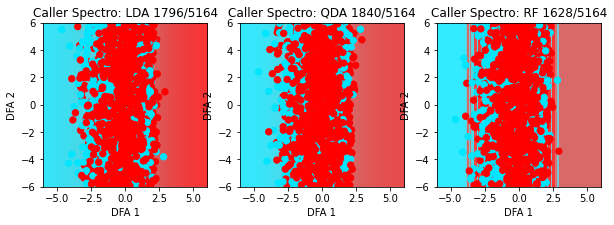

Number of classes 2. Chance level 50.00 %
Caller Spectro LDA: 34.78 % (1796/5164 p=1.0000)
Caller Spectro QDA: 35.63 % (1840/5164 p=1.0000)
Caller Spectro RF: 31.53 % (1628/5164 p=1.0000)


c:\users\tobias\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


<Figure size 432x288 with 0 Axes>

In [19]:
# This code is very similar to tutorial 4.

#  Now we perform the supervised cross-validated and regularized classification:

# y is the grouping variable
y = np.array(vocSelTable['isDeaf'])

# X is the vector of features that will be used 
X = np.vstack(vocSelTable['Spectro'])

# As always it is wise to exclude entries with missing data (should not happen here)
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

groups = vocSelTable['Bird'][nonanInd]

# The classifier. Comment in our out group_hold_out to do GroupStratifiedKFold
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, nClasses, weights, weights_all = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                      cValBirdAll[nonanInd], 
                                                                                      titleStr='Caller Spectro', 
                                                                                      figdir = figdir,
                                                                                      plotFig = True,
                                                                                     group_hold_out = groups)

# Storing the results in a Pandas Data frame (usefull for compilation and further processing)
d = {'Type': np.array(['CallerAdult']),
     'Features': np.array(['Spectrogram']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP])}
     
resultsDataFrame = pd.DataFrame(data = d)



In [ ]:
print(weights_all.shape)
weights_all

In [ ]:
shaped = np.reshape(weights_all, shapeDesired)
plt.imshow(shaped)

In [ ]:
plt.plot(myBioSound.fpsd,myBioSound.psd)


In [ ]:
myBioSound.play()

to do in the future:
1) Take the average of all deaf vs all control  myBioSound.psd's, and compare
2) Look at correctly classified 
